In [84]:
import collections
from time import time
from multiprocessing import Pool, cpu_count
import tqdm  # show multi-processing progress bar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, cohen_kappa_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit, KFold
from xgboost.sklearn import XGBRegressor
import lightgbm as lgb


# for auto reload a module after editing.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load Data

In [42]:
file = "./data/metadata_2014-2019.csv"
df = pd.read_csv(file)
with open("./data/excluded_movies.txt", "r") as f:
    excluded_movies = f.read().split('\n')
df = df[~df['Title'].isin(excluded_movies)]
df = df.reset_index(drop=True)

## 2. Build features

In [43]:
f_company_list = "./data/feature_company_list.txt"
f_mpaa_list = "./data/feature_mpaa_list.txt"
f_genre_list = "./data/feature_genre_list.txt"
f_director_list = "./data/feature_director_list.txt"
f_actor_list = "./data/feature_actor_list.txt"

with open(f_company_list, 'r') as f:
    f_company = f.read().split('\n')[:-1]
with open(f_mpaa_list, 'r') as f:
    f_mpaa = f.read().split('\n')[:-1]
with open(f_genre_list, 'r') as f:
    f_genre = f.read().split('\n')[:-1]
with open(f_director_list, 'r') as f:
    f_director = f.read().split('\n')[:-1]
with open(f_actor_list, 'r') as f:
    f_actor = f.read().split('\n')[:-1]

In [44]:
feature_columns = ['Title', 'tt_id', 'release_date', 'Year', 'budget']\
                + ['company_{}'.format(i) for i in f_company]\
                + ['mpaa_{}'.format(i) for i in f_mpaa]\
                + ['genres_count'] + ['genres_{}'.format(i) for i in f_genre]\
                + ['director_{}'.format(i) for i in f_director]\
                + ['actors_{}'.format(i) for i in f_actor]\
                + ['bo_opening', 'bo_gross', 'imdb_score']
print(len(feature_columns))

108


In [45]:
df_feat = pd.DataFrame(columns = feature_columns)

for f in ['Title', 'tt_id', 'release_date', 'Year', 'budget'] + ['bo_opening', 'bo_gross', 'imdb_score']:
    df_feat.loc[:, f] = df.loc[:, f]
    
for f in f_company:
    df_feat.loc[:, 'company_{}'.format(f)] = df.loc[:, 'company'].apply(lambda x: int(x == f))
    
for f in f_mpaa:
    df_feat.loc[:, 'mpaa_{}'.format(f)] = df.loc[:, 'mpaa'].apply(lambda x: int(x == f))
    
for f in f_director:
    df_feat.loc[:, 'director_{}'.format(f)] = df.loc[:, 'director'].apply(lambda x: int(x == f))

for f in f_genre:
    df_feat.loc[:, 'genres_{}'.format(f)] = df.loc[:, 'genres'].apply(lambda x: int(f in x.split(",")))
df_feat.loc[:, 'genres_count'] = df.loc[:, 'genres'].apply(lambda x: len(x.split(",")))

for f in f_actor:
    df_feat.loc[:, 'actors_{}'.format(f)] = df.loc[:, 'actors'].apply(lambda x: int(f in x.split(",")))
    
df_feat    

,Title,tt_id,release_date,Year,budget,company_Warner Bros.,company_Universal Pictures,company_Lionsgate,company_Twentieth Century Fox,company_Walt Disney Studios Motion Pictures,...,actors_Robert Downey Jr.,actors_Michael Keaton,actors_Johnny Depp,actors_Josh Brolin,actors_Tom Hanks,actors_Michael Fassbender,actors_Vin Diesel,bo_opening,bo_gross,imdb_score
0,Guardians of the Galaxy,tt2015381,2014-08-01,2014,170.0,0,0,0,0,1,...,0,0,0,0,0,0,1,94.320883,333.176600,8.0
1,The Hunger Games: Mockingjay - Part 1,tt1951265,2014-11-21,2014,125.0,0,0,1,0,0,...,0,0,0,0,0,0,0,121.897634,337.135885,6.6
2,Captain America: The Winter Soldier,tt1843866,2014-04-04,2014,170.0,0,0,0,0,1,...,0,0,0,0,0,0,0,95.023721,259.766572,7.7
3,The Lego Movie,tt1490017,2014-02-07,2014,60.0,1,0,0,0,0,...,0,0,0,0,0,0,0,69.050279,257.760692,7.7
4,Transformers: Age of Extinction,tt2109248,2014-06-27,2014,210.0,0,0,0,0,0,...,0,0,0,0,0,0,0,100.038390,245.439076,5.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736,Motherless Brooklyn,tt0385887,2019-11-01,2019,26.0,1,0,0,0,0,...,0,0,0,0,0,0,0,3.500454,9.277736,6.8
737,"Where'd You Go, Bernadette",tt2365580,2019-08-16,2019,20.0,0,0,0,0,0,...,0,0,0,0,0,0,0,3.462308,9.198356,6.5
738,Serenity,tt6476140,2019-01-25,2019,25.0,0,0,0,0,0,...,0,0,0,0,0,0,0,4.415403,8.547045,5.3
739,Jexi,tt9354944,2019-10-11,2019,5.0,0,0,1,0,0,...,0,0,0,0,0,0,0,3.106730,6.546159,6.1


## 3. Build model

In [49]:
X = df_feat.drop(['Title', 'tt_id', 'release_date', 'bo_opening', 'bo_gross', 'imdb_score'], axis=1)
y = df_feat['bo_opening']
train_idx = X[X.Year < 2019].index
test_idx  = X[X.Year == 2019].index
X_train = X.iloc[train_idx, :]
y_train = y.iloc[train_idx]
X_test = X.iloc[test_idx, :]
y_test = y.iloc[test_idx]
print("X_train shape:", X_train.shape)
print("X_test samples:", X_test.shape)

X_train shape: (628, 102)
X_test samples: (113, 102)


In [52]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

In [112]:
def train_model(X, X_test, y, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(X.shape[0])
    prediction = np.zeros(X_test.shape[0])
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('\nFold', fold_n)
        if model_type == 'sklearn':
            X_train, X_valid = X[train_index], X[valid_index]
        else:
            X_train, X_valid = X.values[train_index], X.values[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 100, nthread = 4, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                    verbose=1000, early_stopping_rounds=30)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test.values), ntree_limit=model.best_ntree_limit)

        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_squared_error(y_valid, y_pred_valid)
            
            y_pred = model.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='RMSE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)
        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    print('CV mean score: {0:.3f}, std: {1:.3f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:30].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction


Fold 0
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 22.9491	valid_1's rmse: 22.0606

Fold 1
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 22.771	valid_1's rmse: 21.8956

Fold 2
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 22.6706	valid_1's rmse: 23.0389

Fold 3
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 21.6494	valid_1's rmse: 29.5159

Fold 4
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 22.2003	valid_1's rmse: 25.5426
CV mean score: 24.411, std: 2.866.


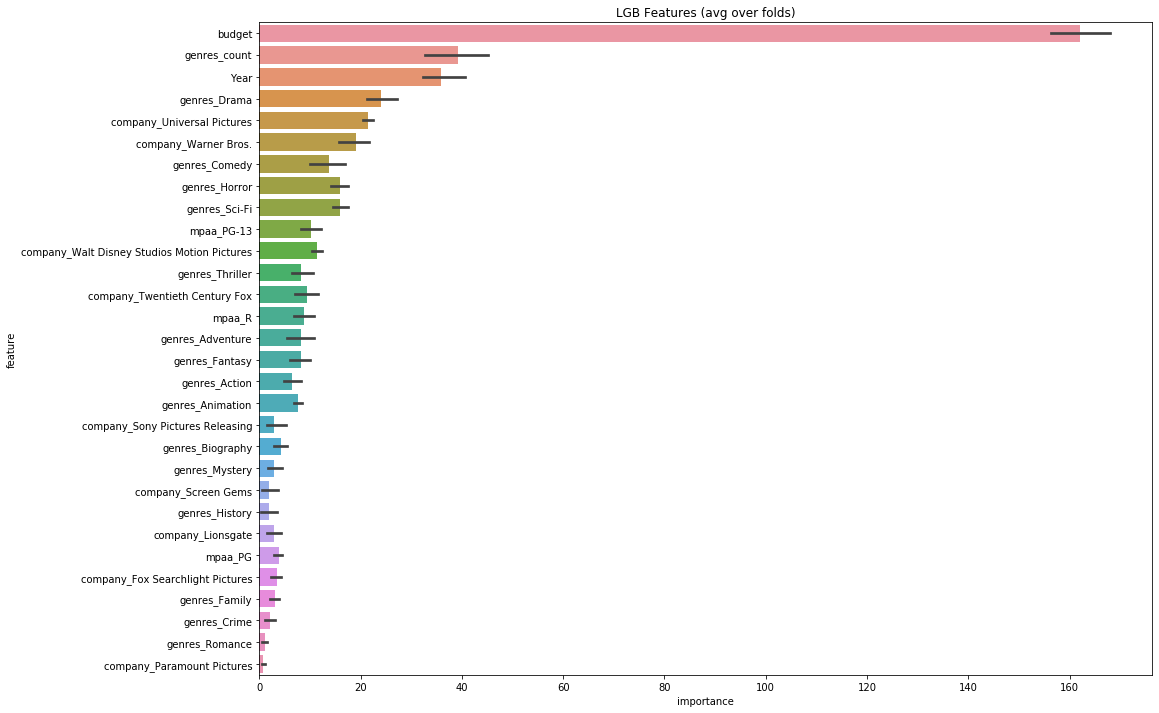

In [113]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 10,
         'objective': 'regression',
         'max_depth': 7,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb, prediction_lgb, _ = train_model(X_train, X_test, y_train, params=params, model_type='lgb', plot_feature_importance=True)

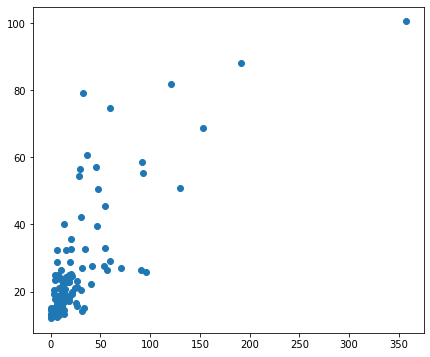

In [114]:
plt.figure(figsize=(7, 6))
plt.scatter(y_test, prediction_lgb)

In [115]:
r2_score(oof_lgb, y_train)

-1.236747759393673

In [116]:
r2_score(prediction_lgb, y_test)

-2.6713618810728783

In [117]:
def plot_scatter_preds(preds, truth):
    fig = plt.figure(figsize=(6, 6))
    sns.regplot(truth, preds, marker="+")
    
    min_ = 0
    max_ = 200 #max(preds.max(), truth.max())
    
    x = np.linspace(min_, max_, 100)
    y130 = x * 1.3
    y70 = x * 0.7
    
    plt.plot(x, x, 'g', linewidth=3)
#     plt.plot(x, y130, 'y', linewidth=3)
#     plt.plot(x, y70, 'y', linewidth=3)
    plt.xlim(min_, max_)
    plt.ylim(min_, max_)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel("truth")
    plt.ylabel("predictions")
    plt.title("Pred. vs. Truth ")
    return fig

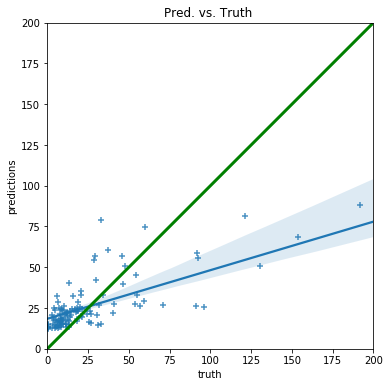

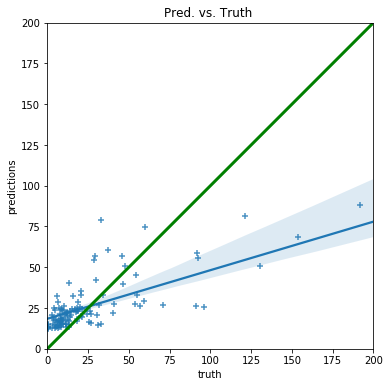

In [118]:
plot_scatter_preds(prediction_lgb, y_test)